<a href="https://colab.research.google.com/github/PyAshishMhatre/DigitalMarketing-Algorithms-Project/blob/main/DemandForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading data 
distribution_centers = pd.read_csv('distribution_centers.csv')
inventory_items = pd.read_csv('inventory_items.csv')
order_items = pd.read_csv('order_items.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
users = pd.read_csv('users.csv')

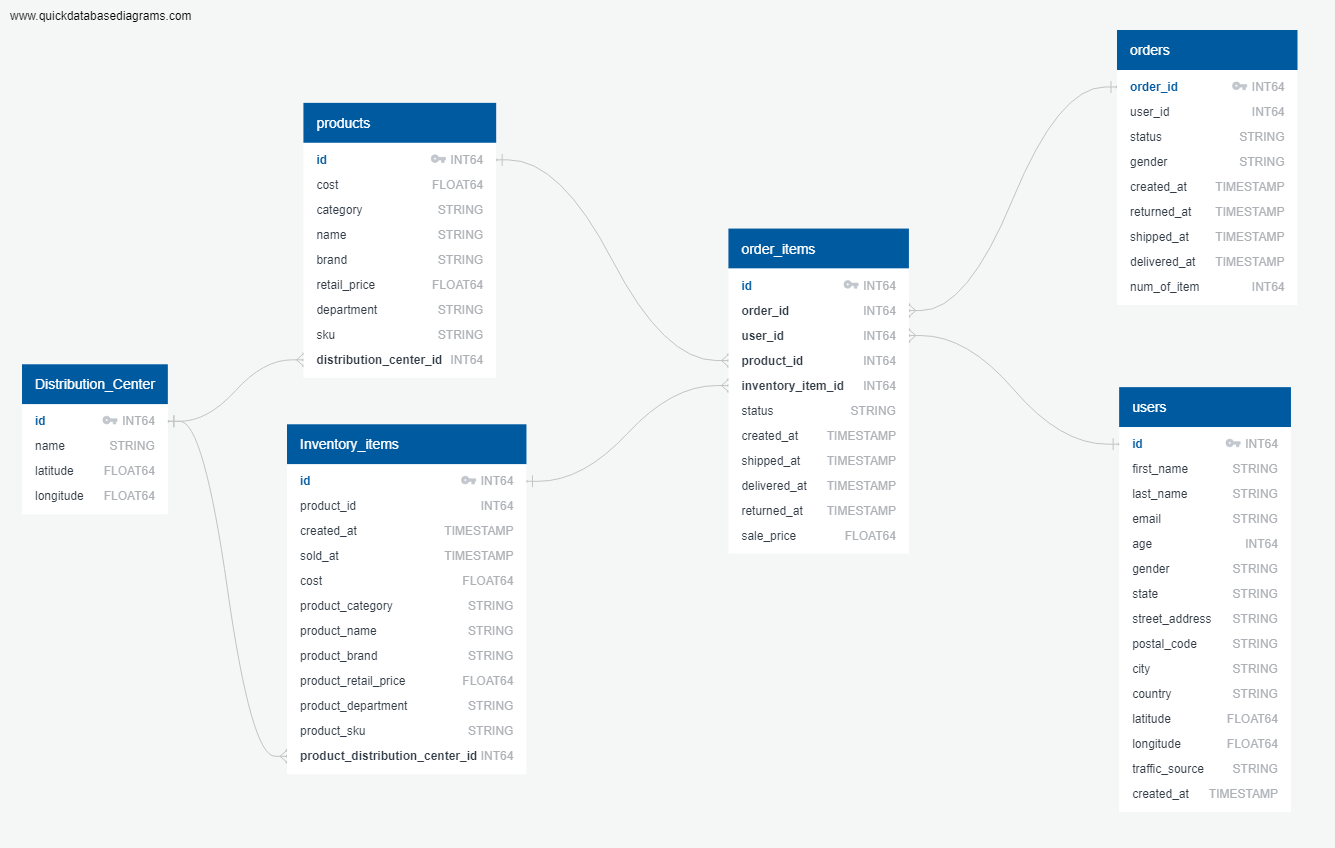

# Analysis

In [7]:
# Ploting the timeline for count of items sold by product type

count_product = order_items.groupby(['created_at', 'product_id']).size().reset_index(name='count')
count_product = count_product.sort_values(by = ['created_at', 'product_id'])

In [14]:
print(count_product.head())

print('\n We have {a} unique products'.format(a = len(count_product['product_id'].unique())))

                created_at  product_id  count
0  2019-01-06 04:19:39 UTC       28643      1
1  2019-01-06 08:46:59 UTC       20835      1
2  2019-01-07 07:27:40 UTC       23736      1
3  2019-01-09 04:02:14 UTC       23959      1
4  2019-01-10 04:28:59 UTC        4074      1

 We have 29057 unique products


## Analysing 29057 is difficult and we wont be forecasting data at such granular level thus we will merge the dataset with products to get a broader category to work with forecasting 

Checking what can be our broader category for analysis

In [23]:
len(products['category'].unique())

# Since category has a workable count we will consider category as our agg variable

26

In [27]:
print(' \n Length before merging ',len(order_items))

order_items_product = pd.merge(order_items, products, how='inner', left_on='product_id', right_on='id')

print(' \n Length after merging ',len(order_items_product))

 
 Length before merging  181622
 
 Length after merging  181622


In [30]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,id_y,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15 UTC,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,2.5,13606,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28 UTC,2022-12-31 00:13:00 UTC,NaN,NaN,3.0,28951,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6


In [34]:
order_items_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181622 entries, 0 to 181621
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_x                    181622 non-null  int64  
 1   order_id                181622 non-null  int64  
 2   user_id                 181622 non-null  int64  
 3   product_id              181622 non-null  int64  
 4   inventory_item_id       181622 non-null  int64  
 5   status                  181622 non-null  object 
 6   created_at              181622 non-null  object 
 7   shipped_at              117819 non-null  object 
 8   delivered_at            63723 non-null   object 
 9   returned_at             18378 non-null   object 
 10  sale_price              181622 non-null  float64
 11  id_y                    181622 non-null  int64  
 12  cost                    181622 non-null  float64
 13  category                181622 non-null  object 
 14  name                

In [35]:
# Converting to date time 
order_items_product['created_at'] = pd.to_datetime(order_items_product['created_at'], utc=True)

In [37]:
order_items_product['created_at'].info()

<class 'pandas.core.series.Series'>
Int64Index: 181622 entries, 0 to 181621
Series name: created_at
Non-Null Count   Dtype              
--------------   -----              
181622 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 2.8 MB


In [38]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,id_y,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15+00:00,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,2.5,13606,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28+00:00,2022-12-31 00:13:00 UTC,NaN,NaN,3.0,28951,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6


In [39]:
order_items_product['year'] = order_items_product['created_at'].dt.year
order_items_product['month'] = order_items_product['created_at'].dt.month
order_items_product['day'] = order_items_product['created_at'].dt.day

In [40]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,...,category,name,brand,retail_price,department,sku,distribution_center_id,year,month,day
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15+00:00,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,...,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3,2022,8,7
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28+00:00,2022-12-31 00:13:00 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2022,12,31


In [41]:
count_productcat = order_items_product.groupby(['year','month','category']).size().reset_index(name='count')
count_productcat = count_productcat.sort_values(by = ['year','month', 'category'])

In [47]:
count_productcat.head(5)

,category,count,date
0,Accessories,3,2019-01-01
1,Active,2,2019-01-01
2,Fashion Hoodies & Sweatshirts,2,2019-01-01
3,Intimates,2,2019-01-01
4,Jeans,3,2019-01-01


In [46]:
# convert the 'year' and 'month' columns to a datetime format
count_productcat['date'] = pd.to_datetime(count_productcat['year'].astype(str) + '-' + count_productcat['month'].astype(str), format='%Y-%m')
count_productcat = count_productcat.drop(['year', 'month'], axis=1)



In [49]:
count_productcat.head(5)

,category,count,date
0,Accessories,3,2019-01-01
1,Active,2,2019-01-01
2,Fashion Hoodies & Sweatshirts,2,2019-01-01
3,Intimates,2,2019-01-01
4,Jeans,3,2019-01-01


In [51]:
count_productcat['category'].unique()

array(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts',
       'Intimates', 'Jeans', 'Jumpsuits & Rompers', 'Leggings',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Socks & Hosiery', 'Suits & Sport Coats', 'Sweaters', 'Swim',
       'Underwear', 'Blazers & Jackets', 'Clothing Sets', 'Dresses',
       'Maternity', 'Pants & Capris', 'Plus', 'Skirts', 'Suits',
       'Tops & Tees'], dtype=object)

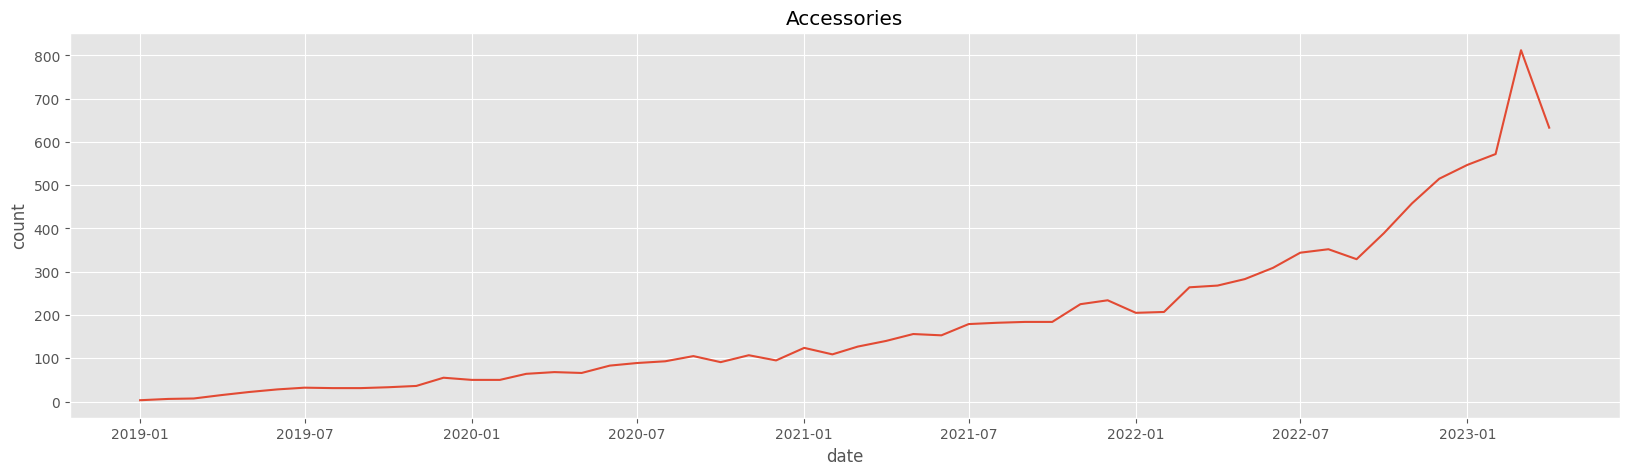

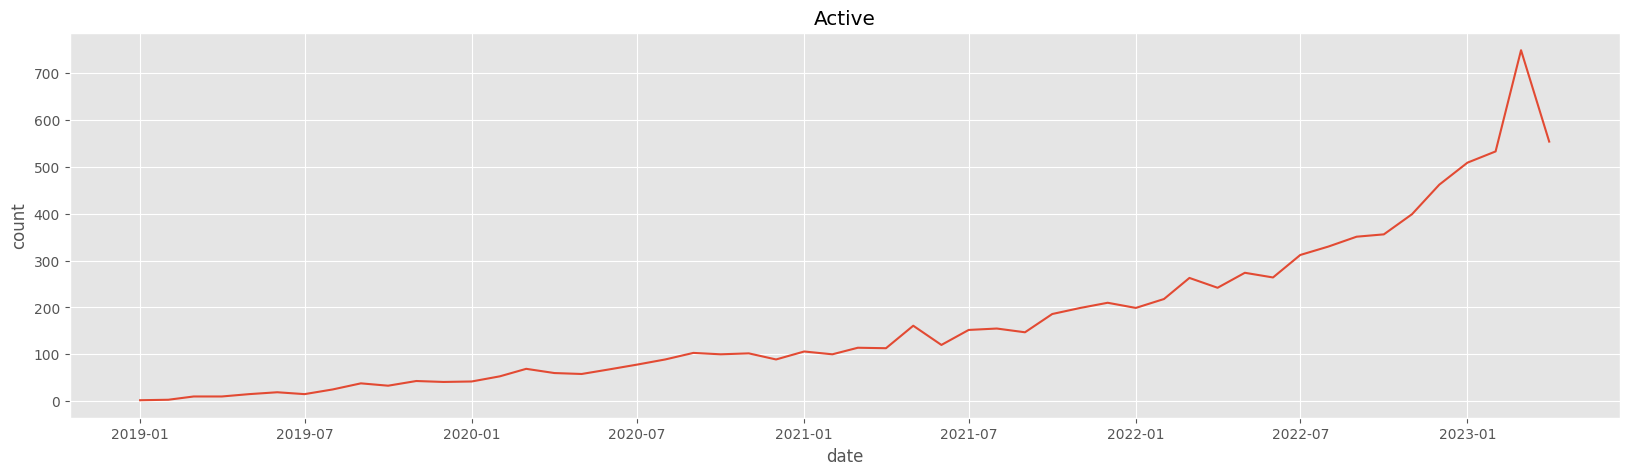

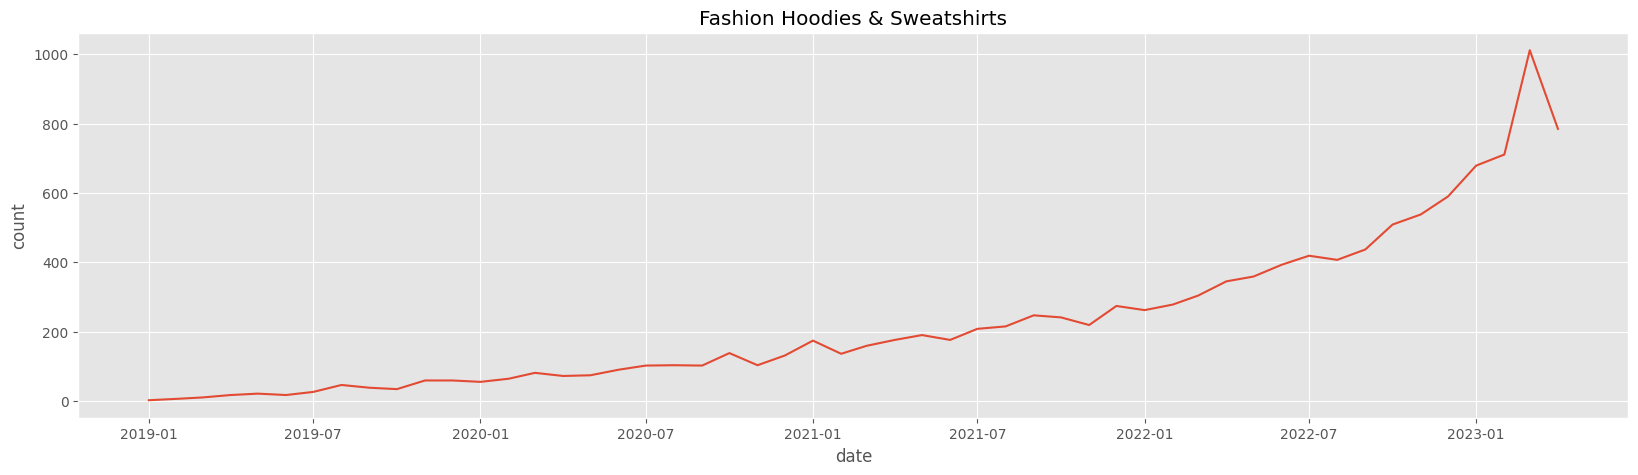

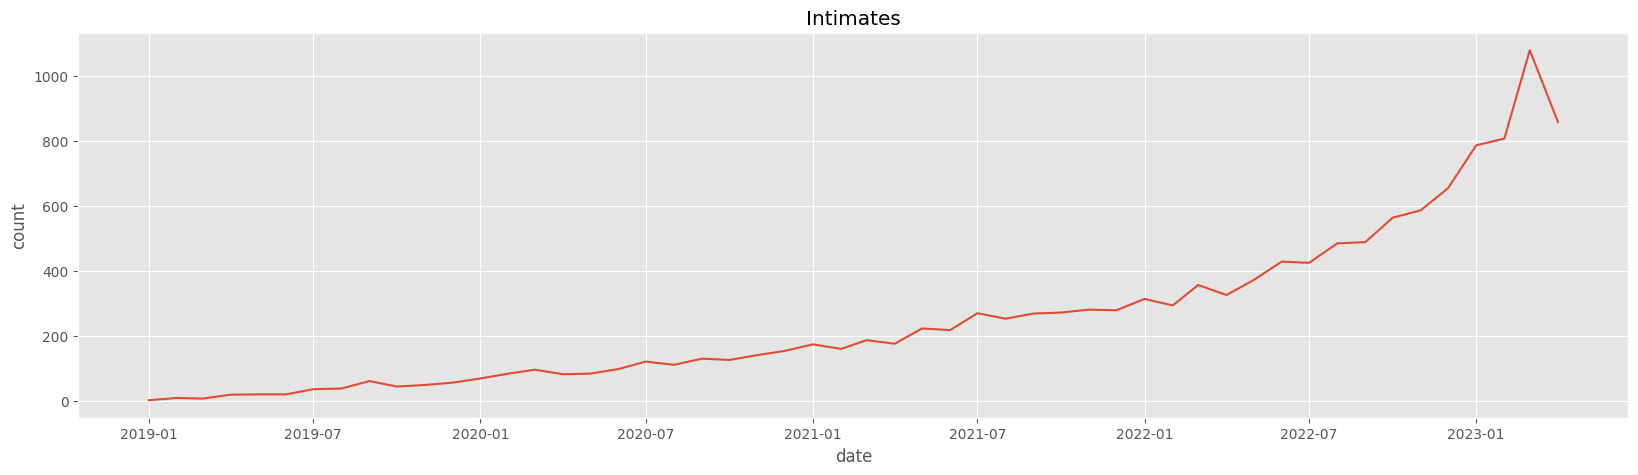

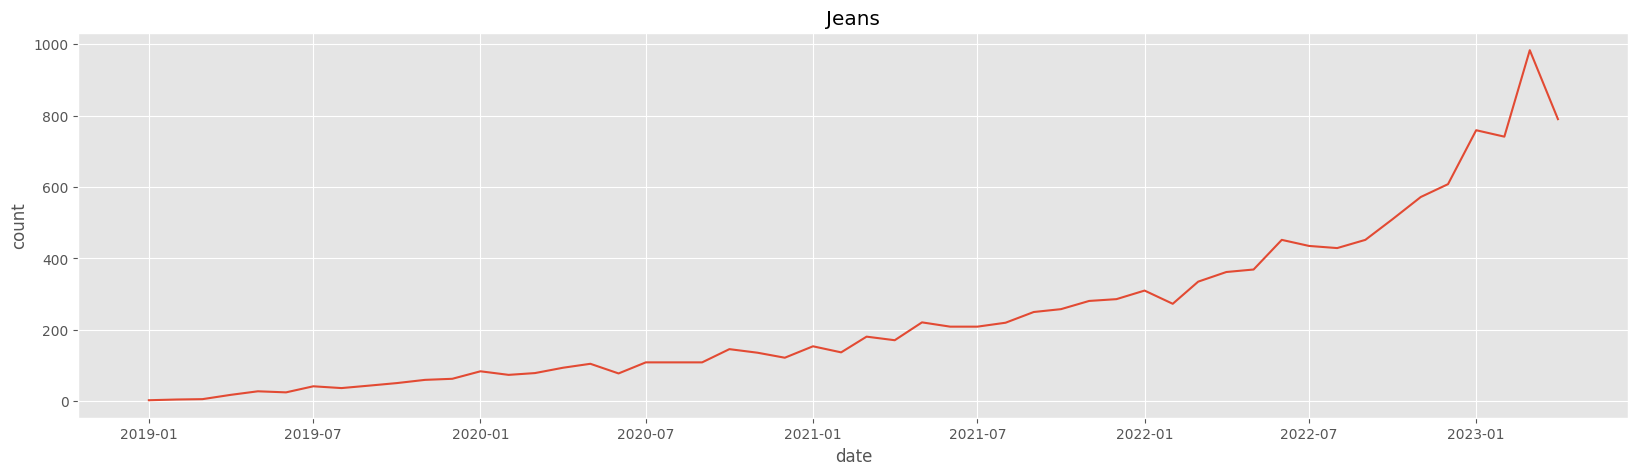

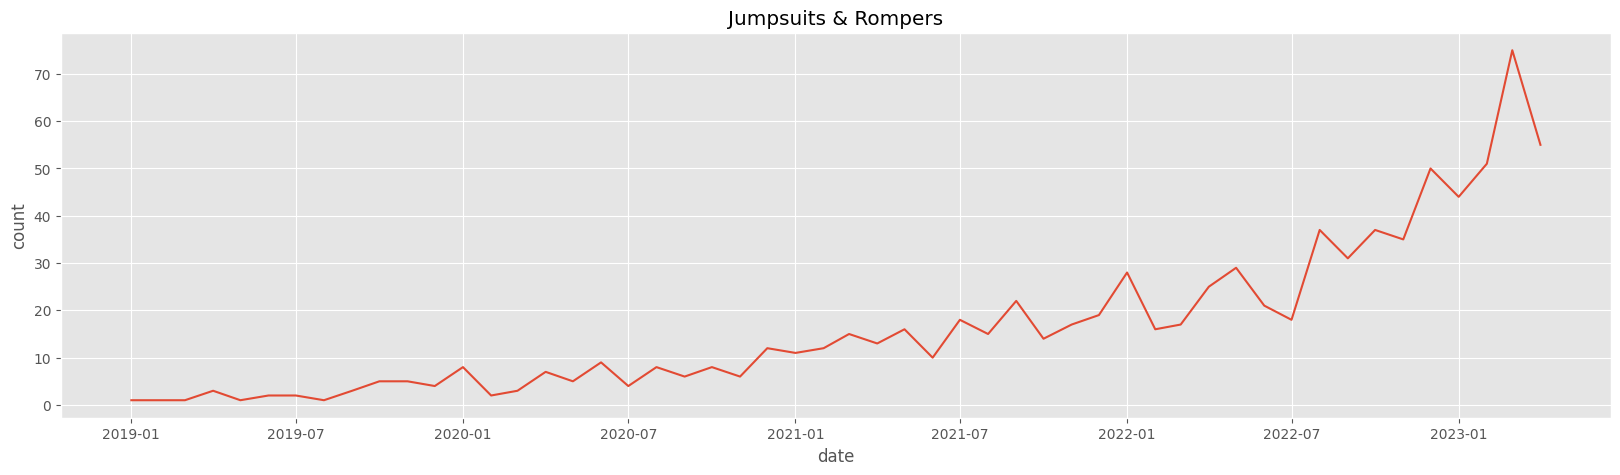

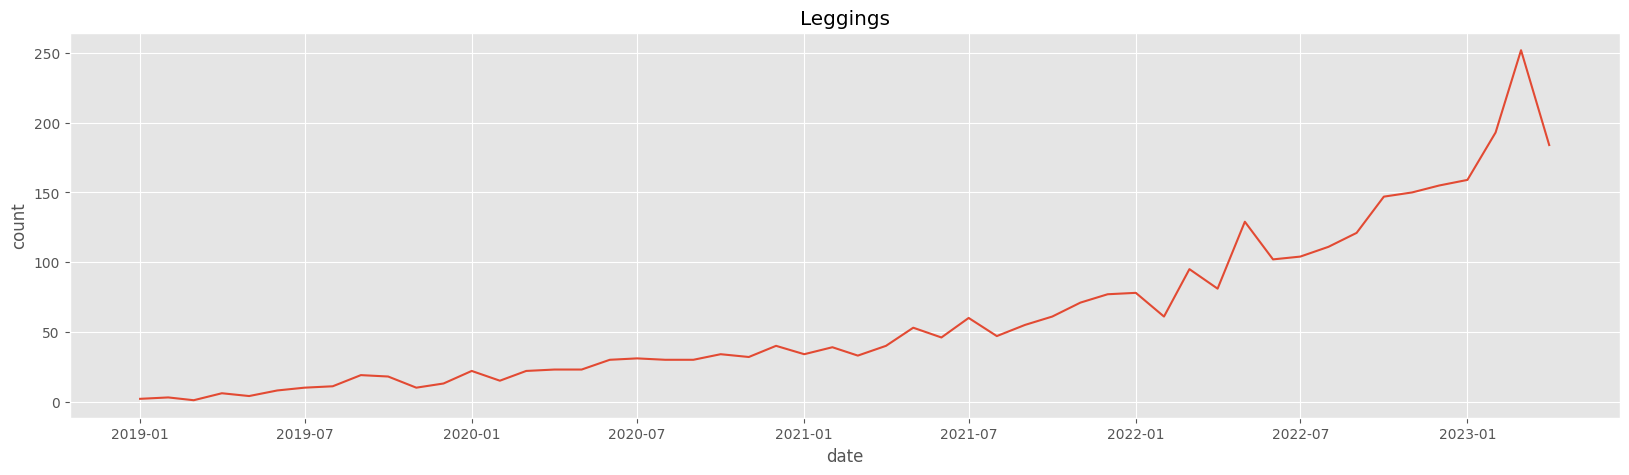

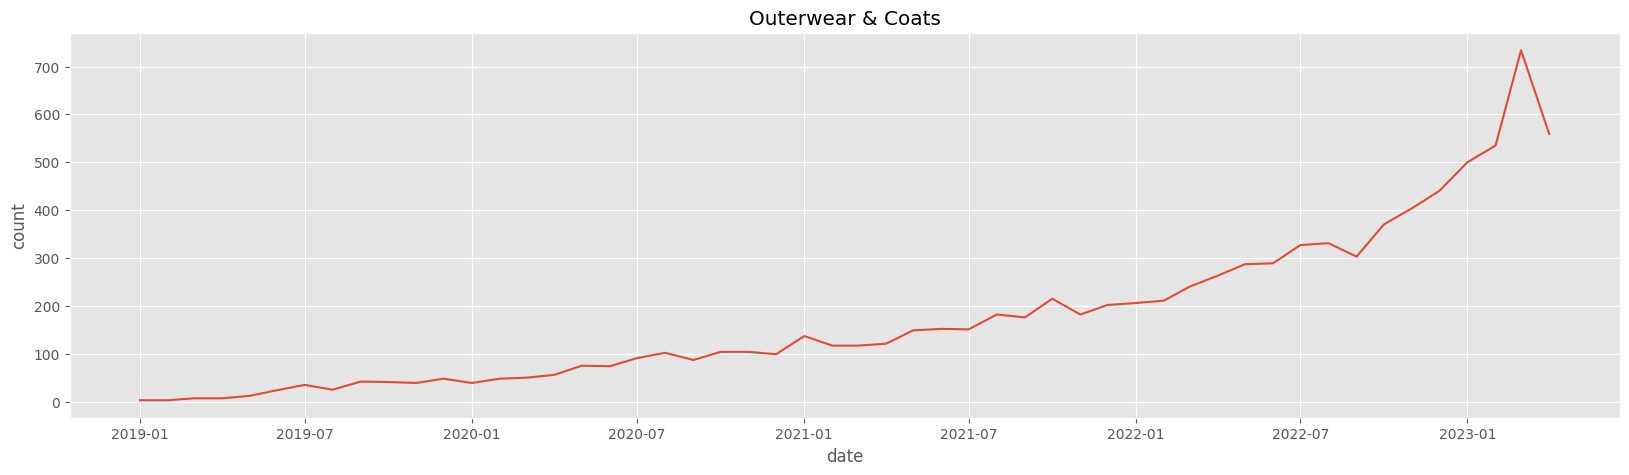

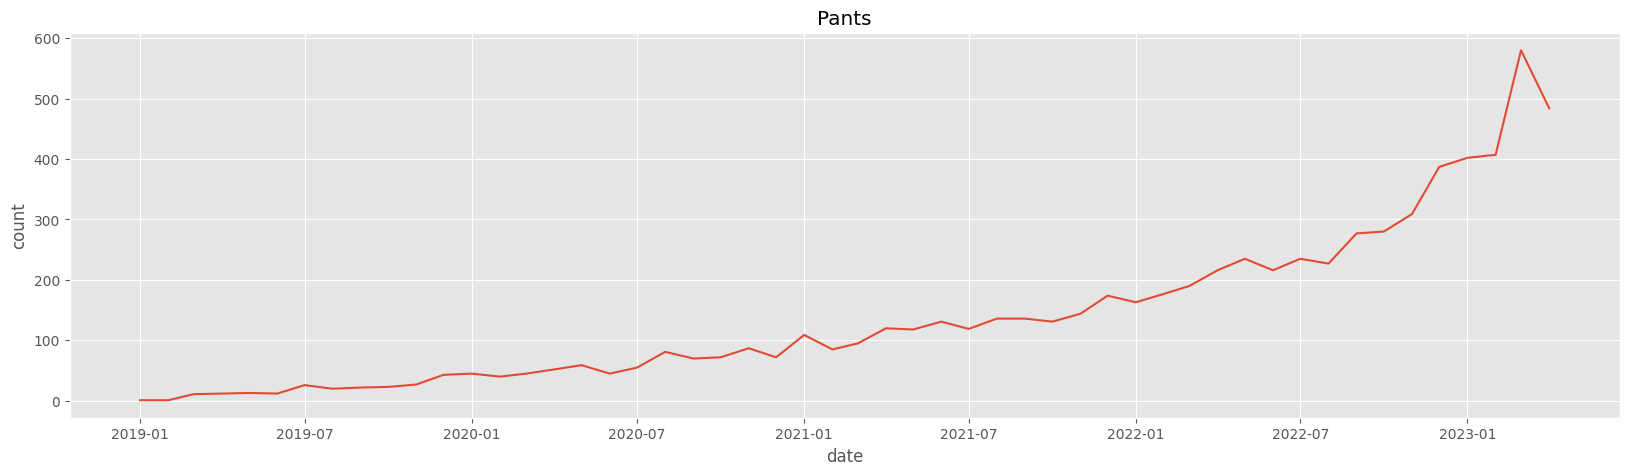

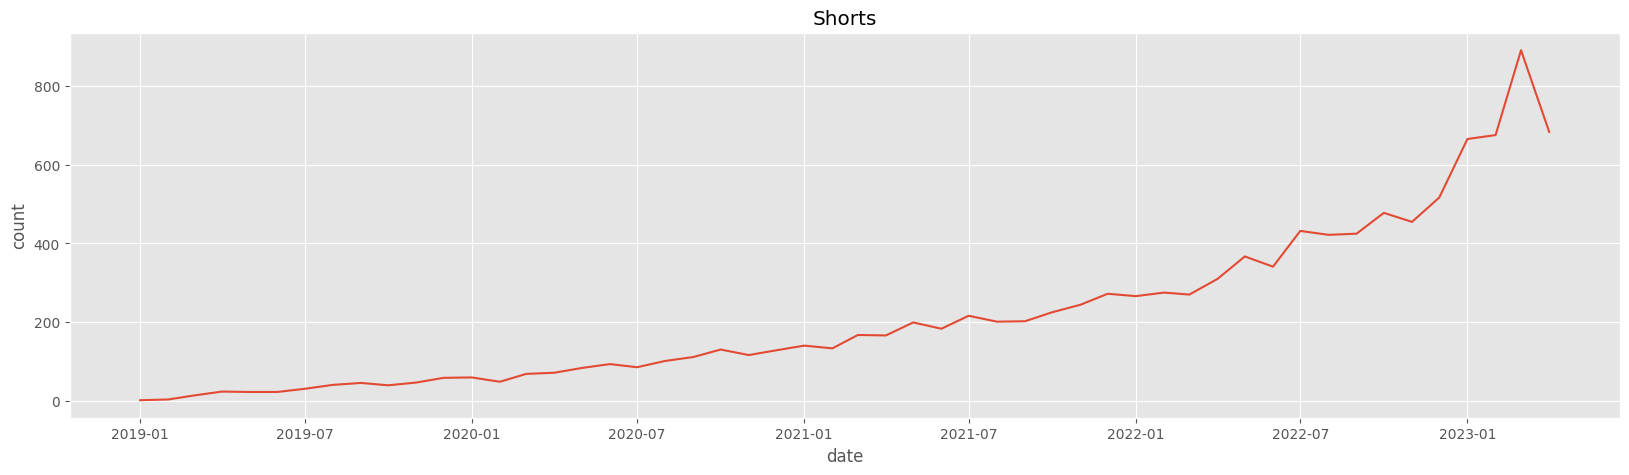

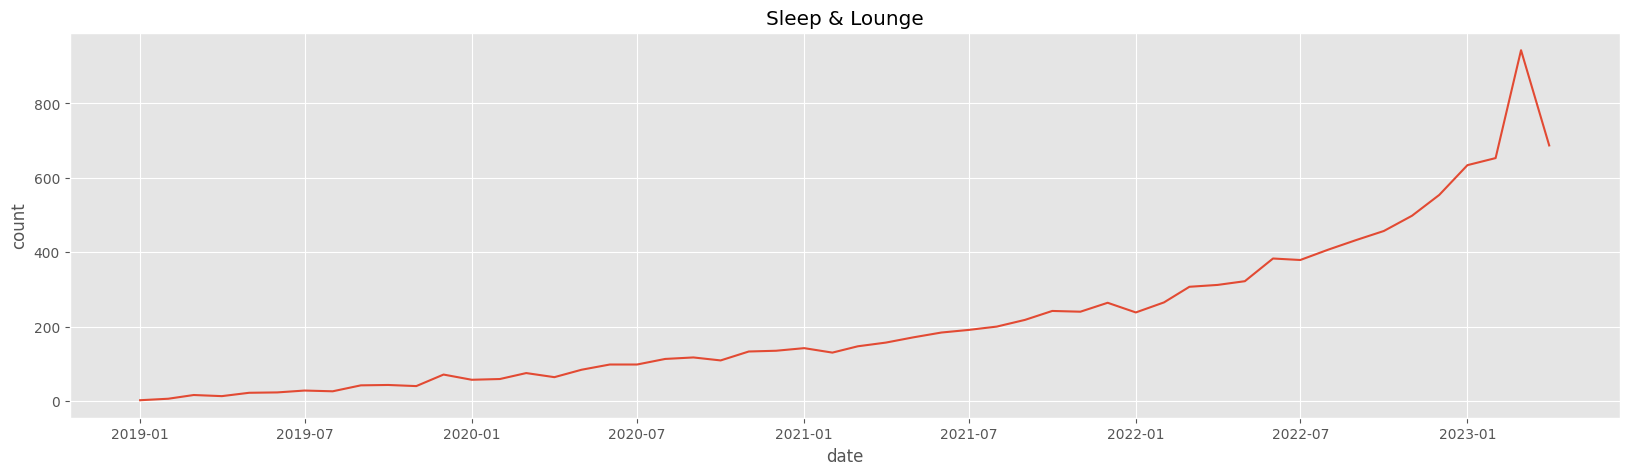

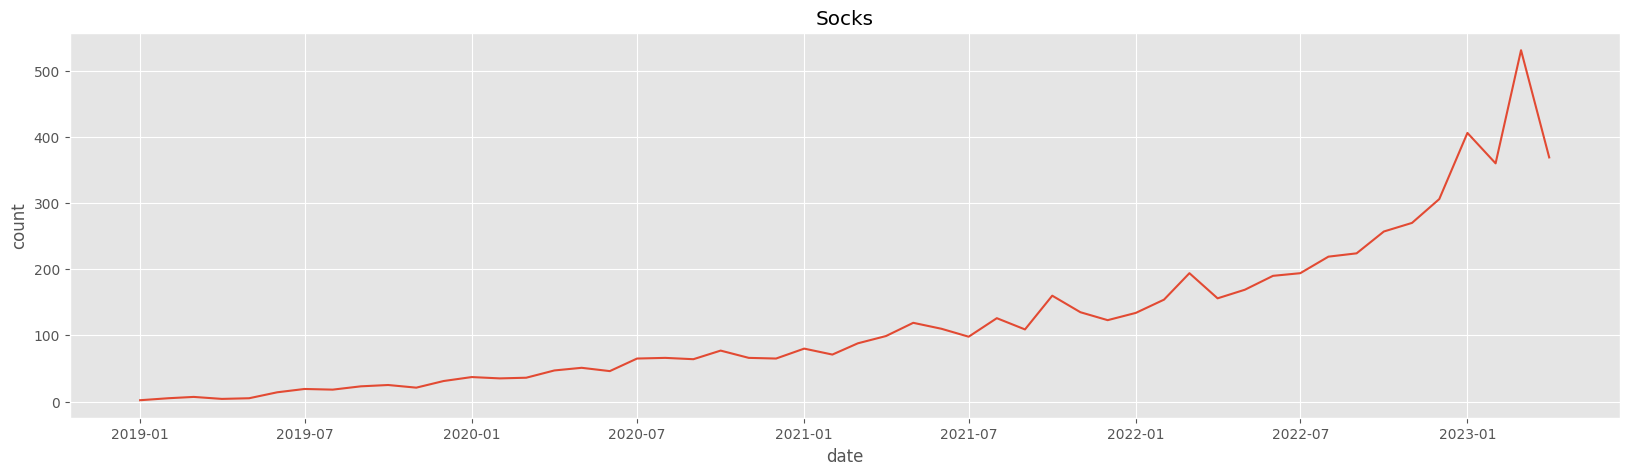

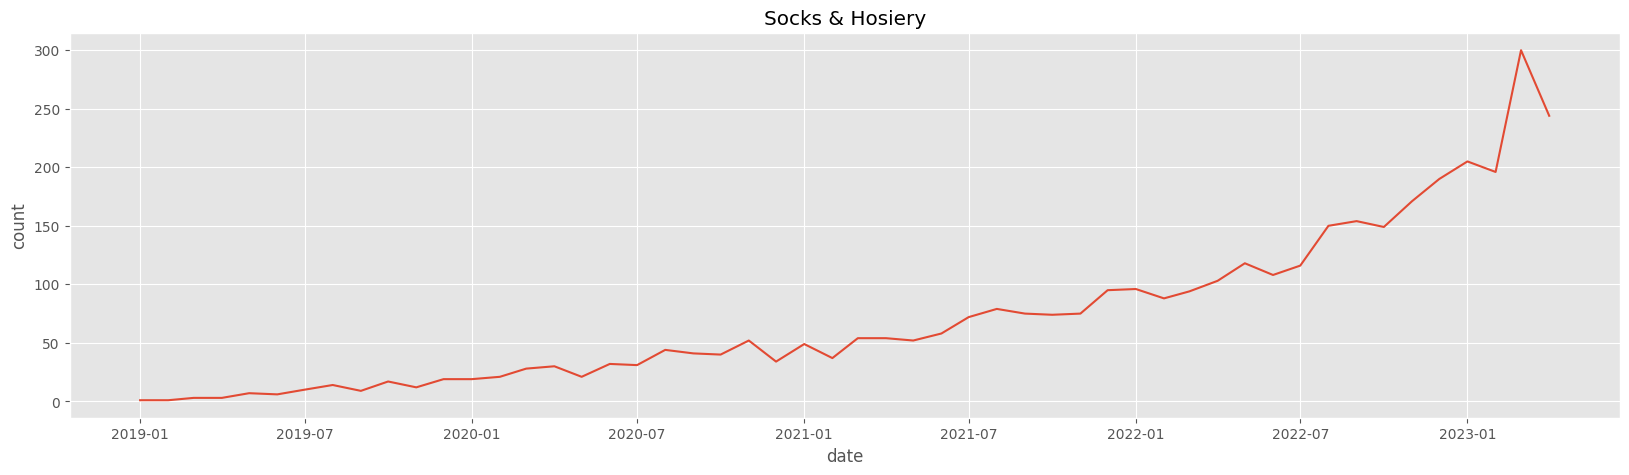

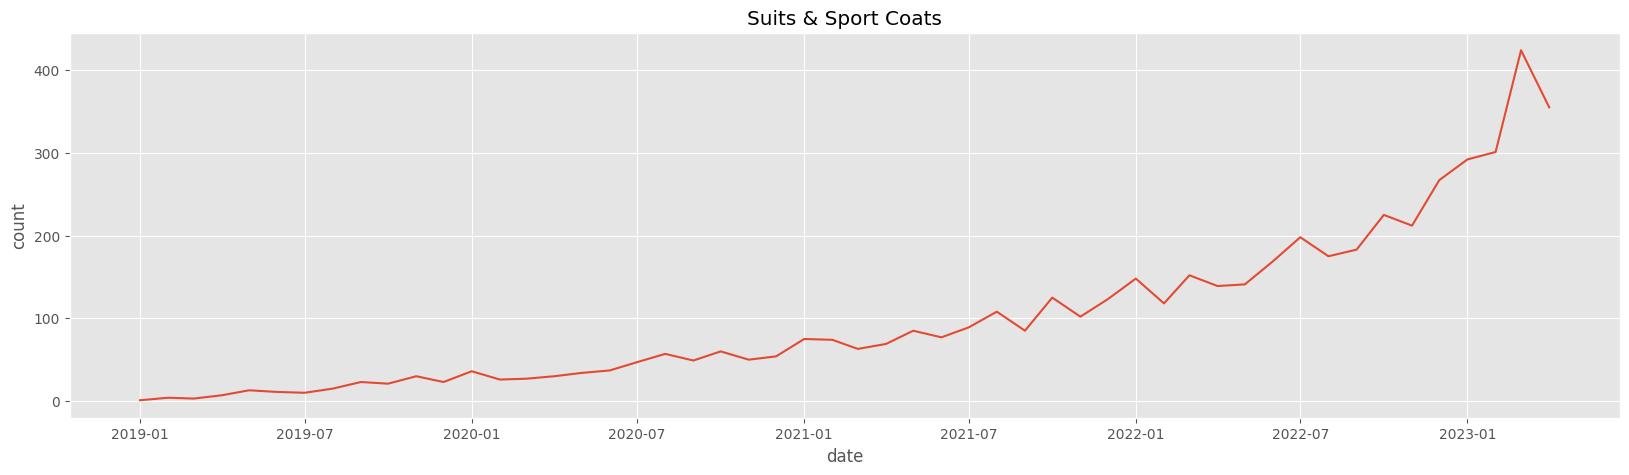

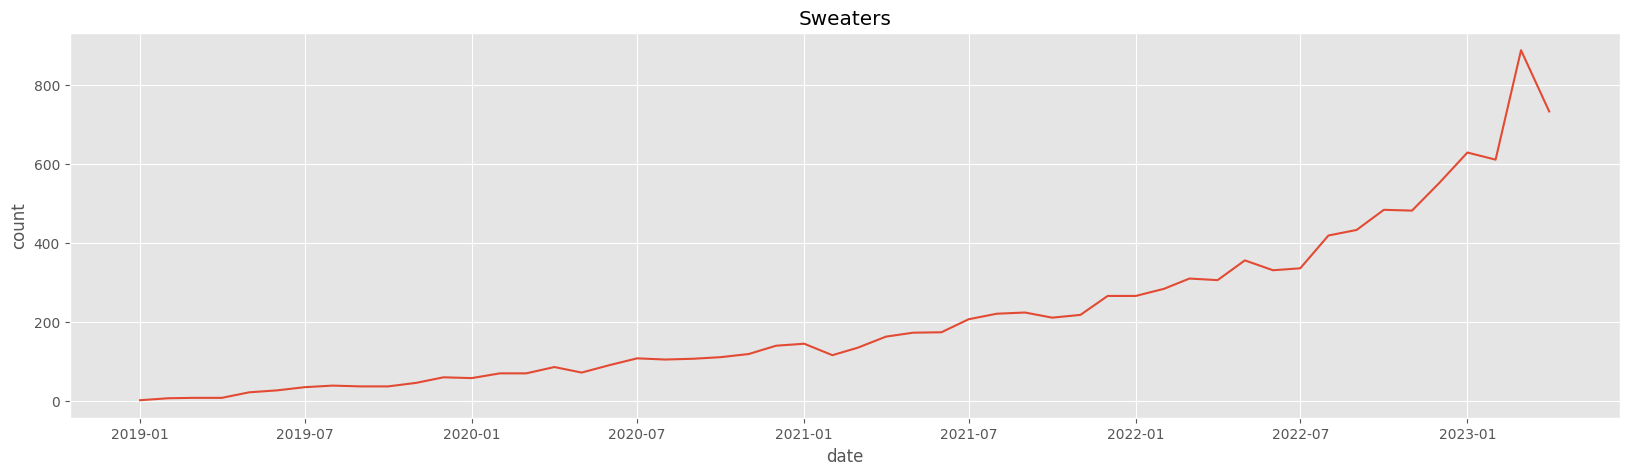

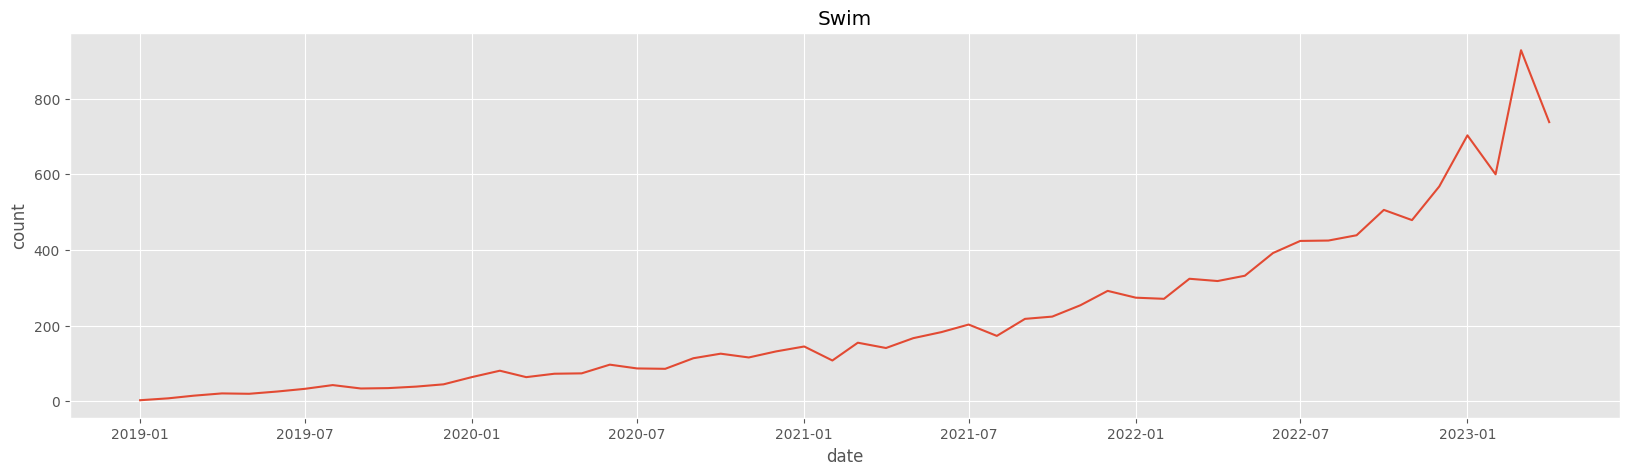

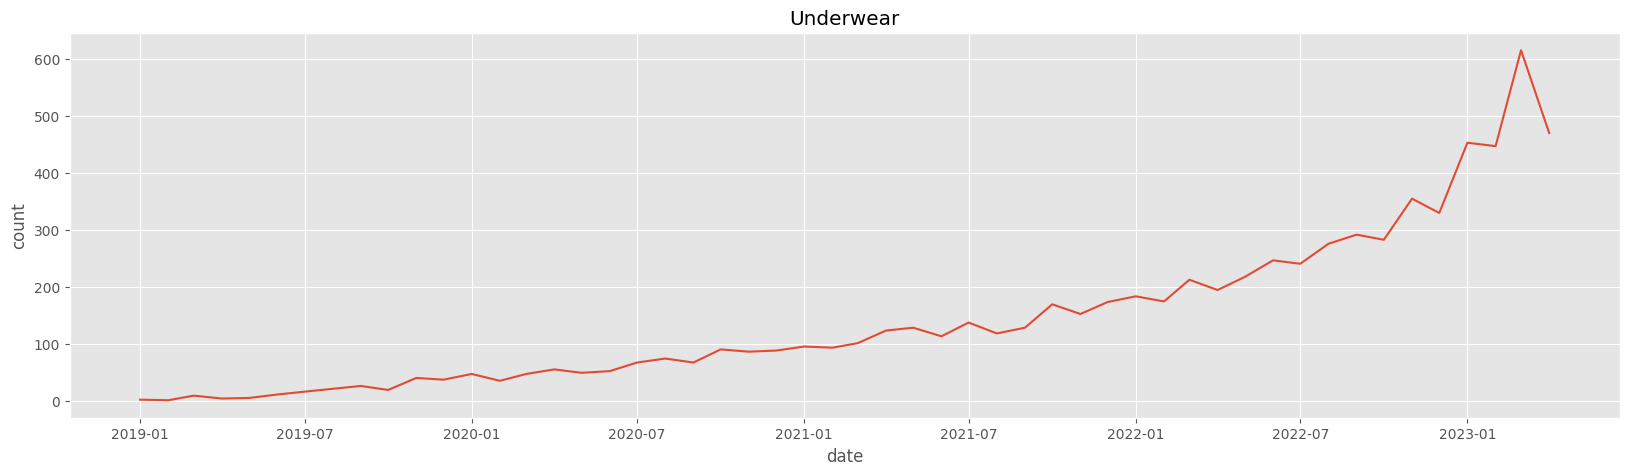

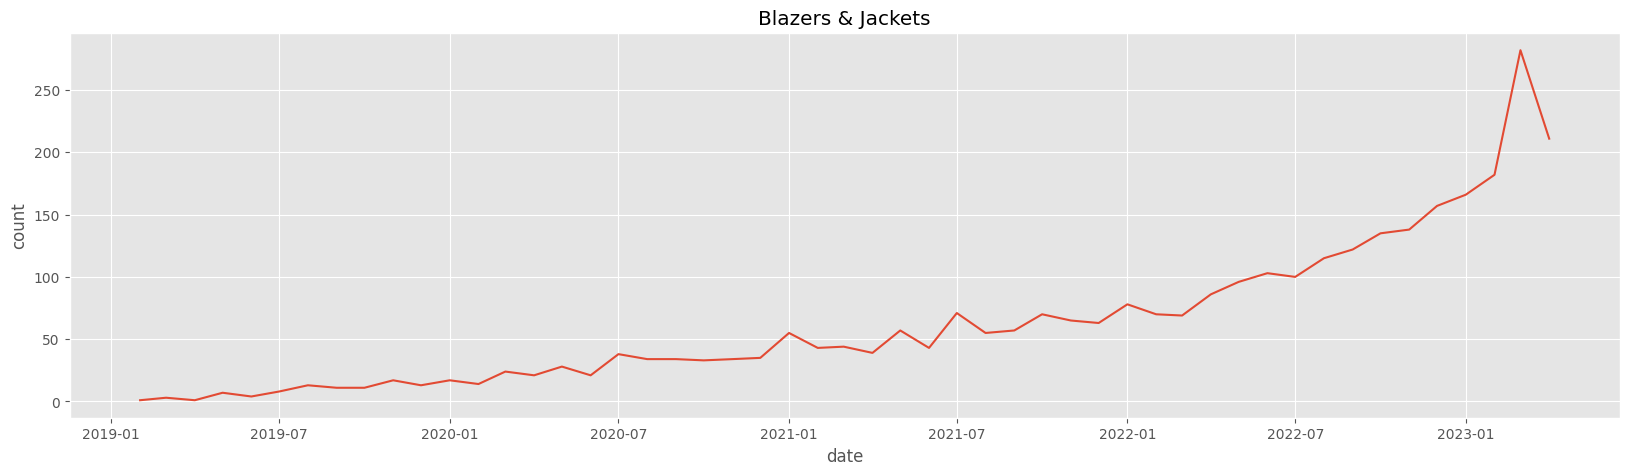

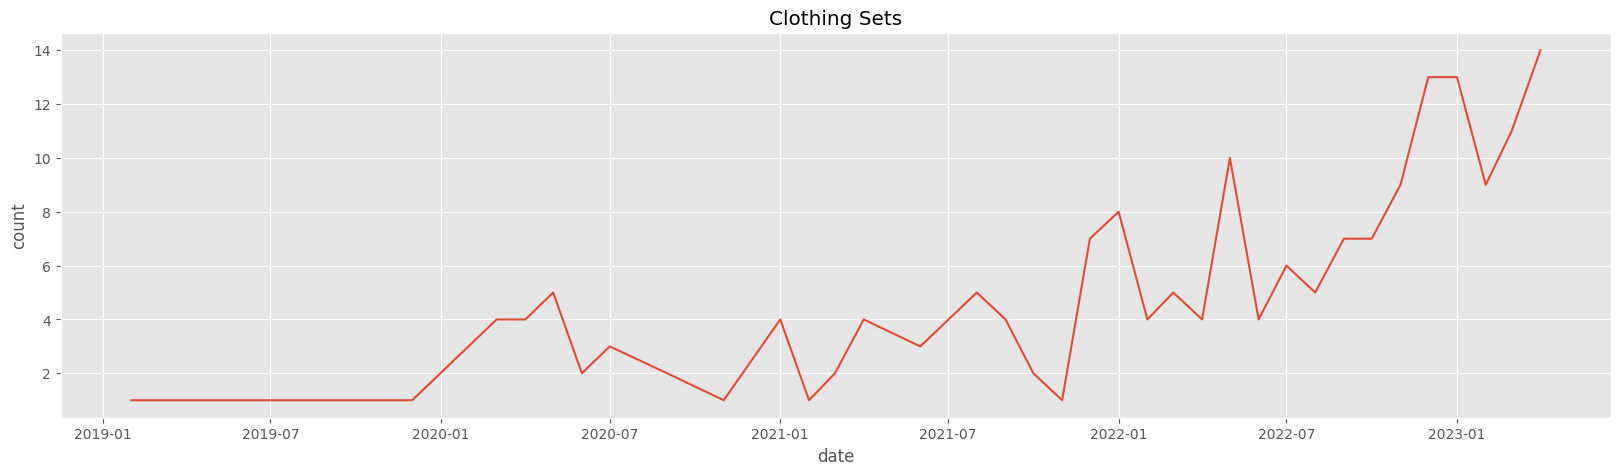

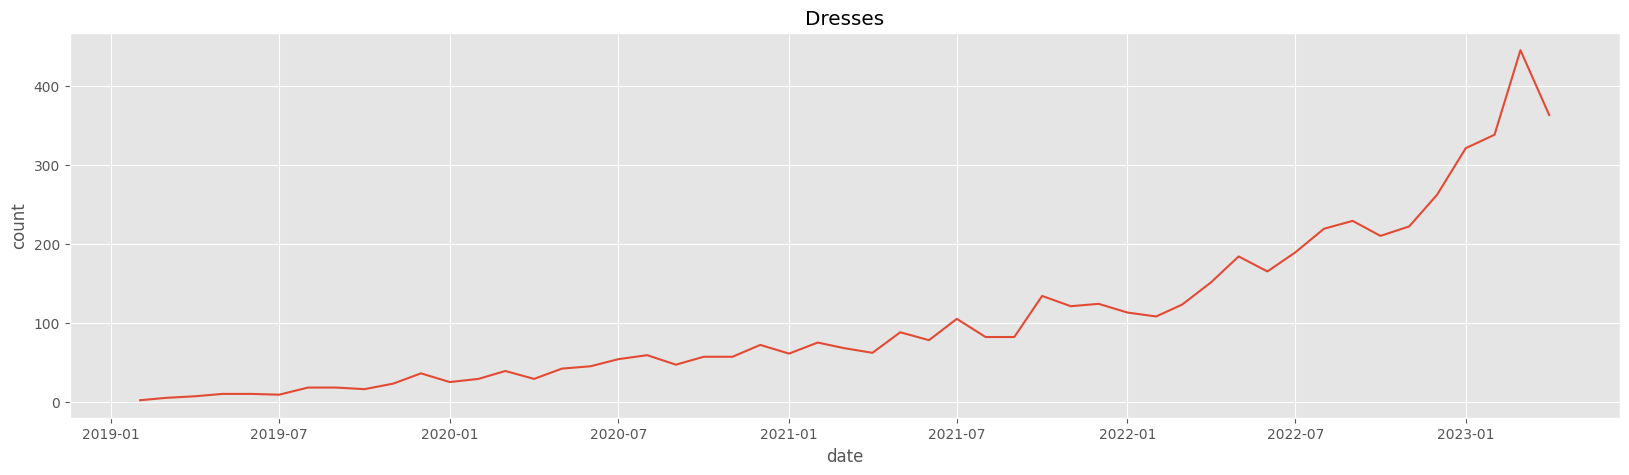

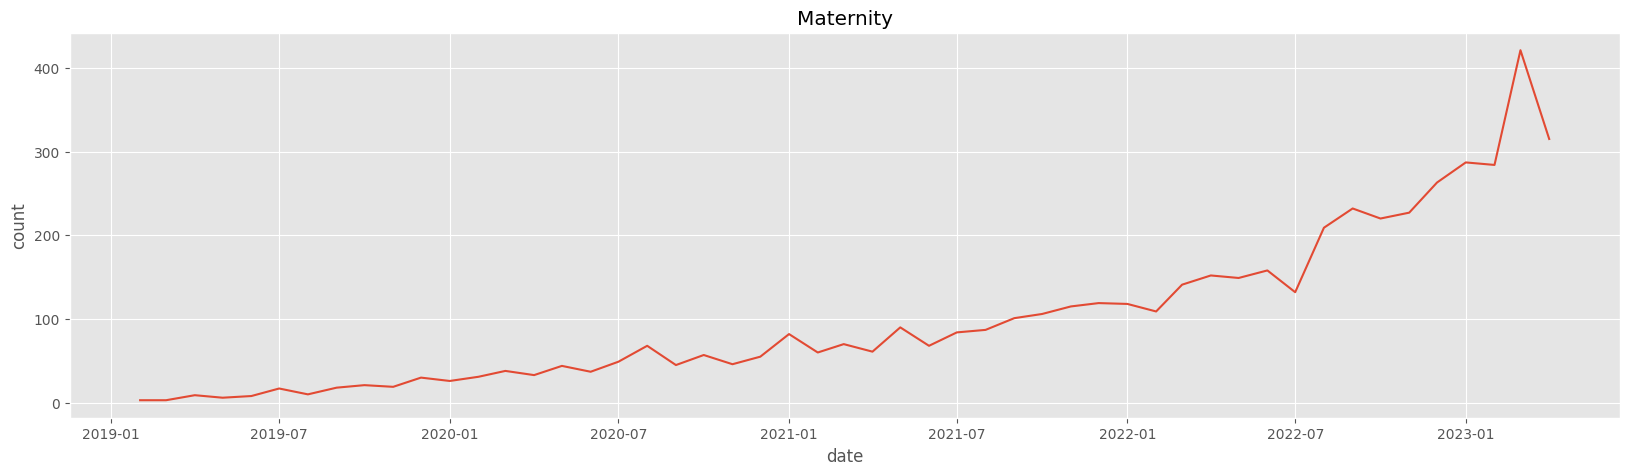

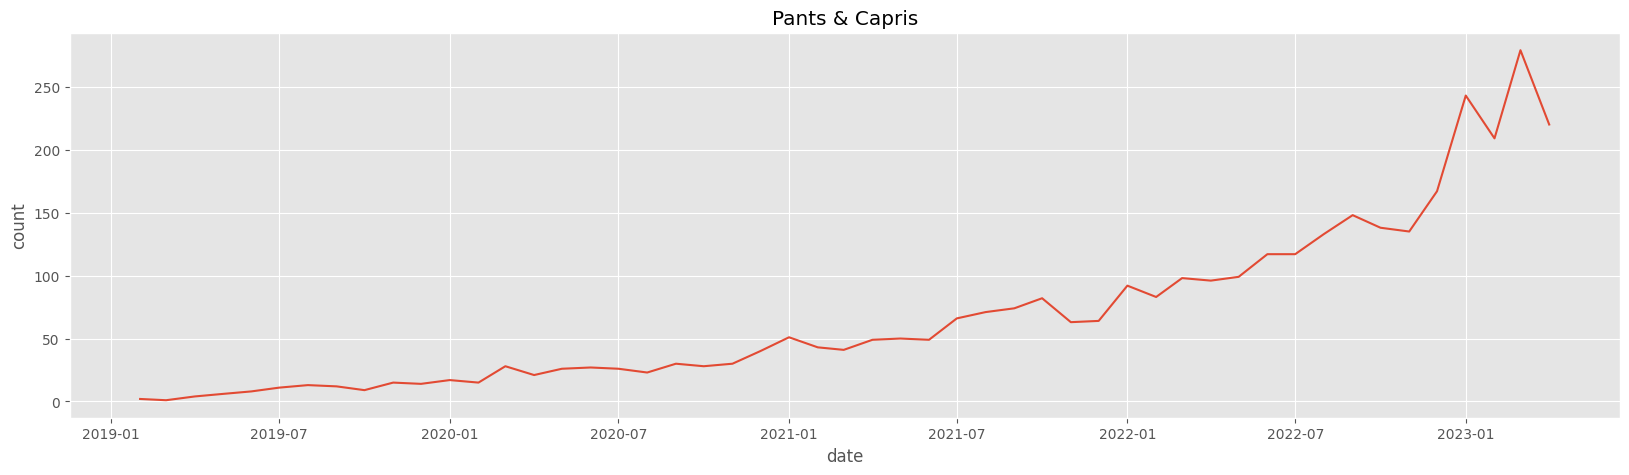

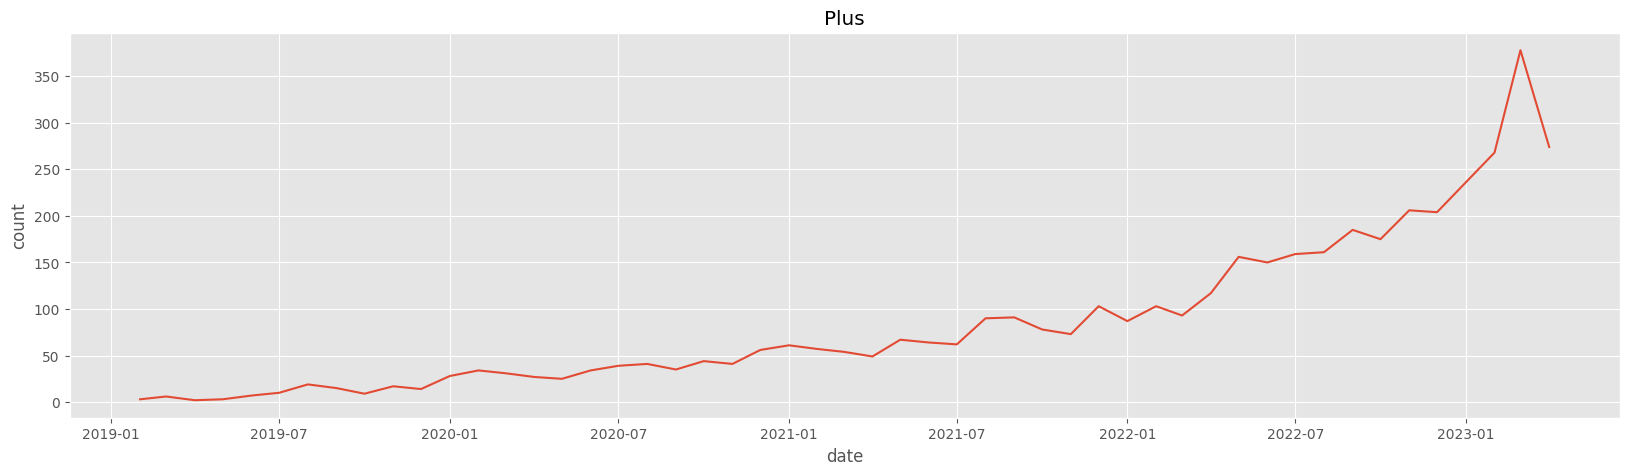

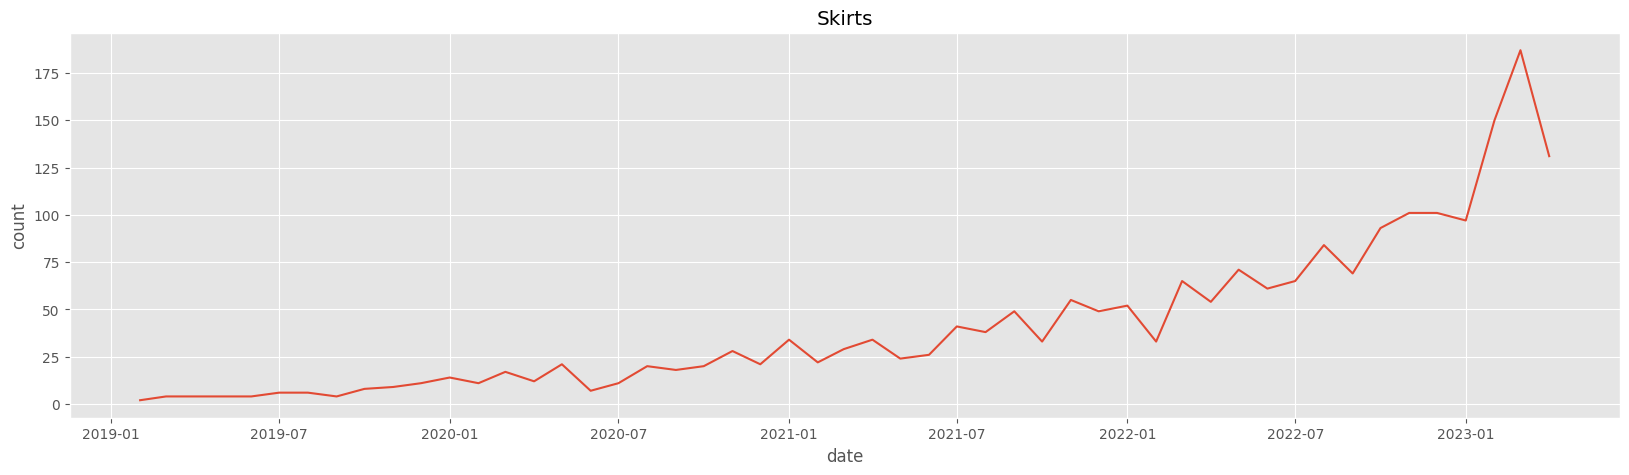

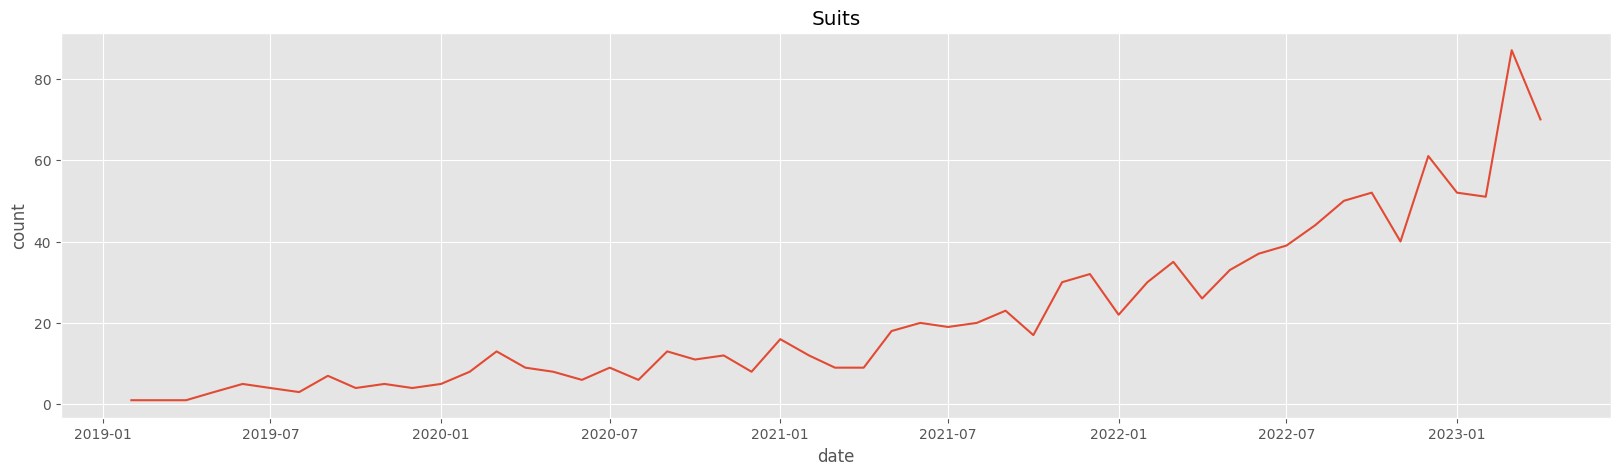

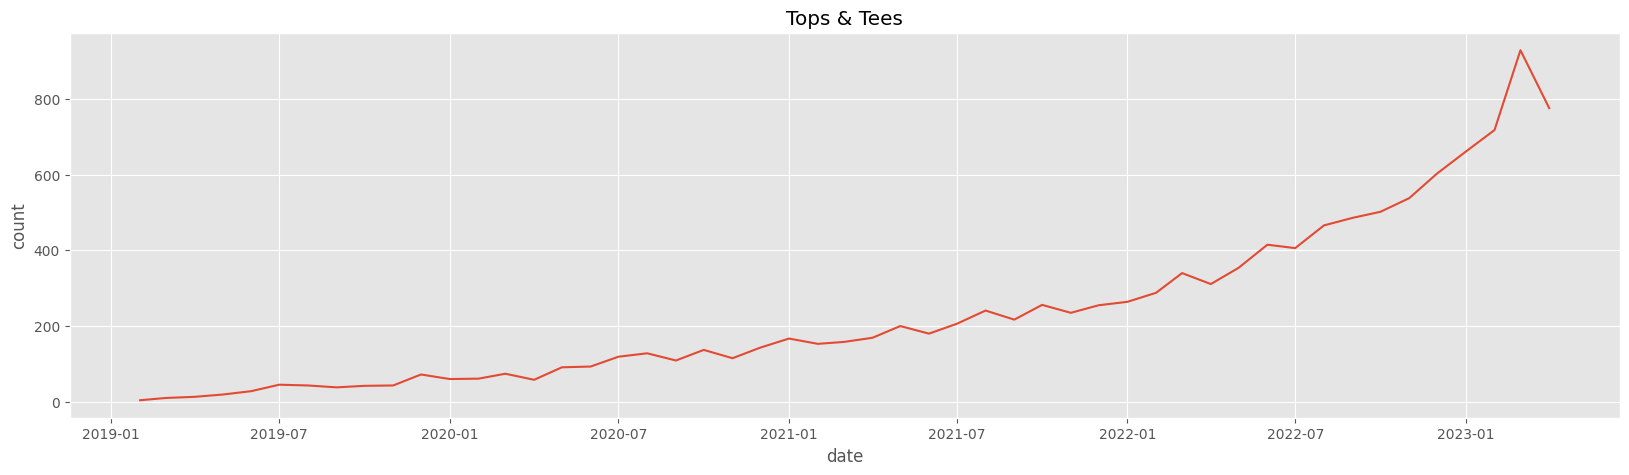

In [57]:
# plot the line graph

plt.style.use('ggplot')
for category in count_productcat['category'].unique():
    plt.subplots(figsize=(20, 5))
    count_productcat_category = count_productcat[count_productcat['category'] == category]
    sns.lineplot(data=count_productcat_category, x='date', y='count')
    plt.title(category)
    plt.show()